In [1]:
import numpy as np

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset
from l5kit.rasterization import build_rasterizer

import os
import copy
from itertools import cycle, combinations

import sys
sys.path.append('../..')

import backpack

In [2]:
os.environ['L5KIT_DATA_FOLDER'] = '../../dataset'
dm = LocalDataManager(None)

cfg = load_config_data('./config.yaml')
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False}, 'train_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': True, 'num_workers': 16}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}, 'train_params': {'checkpoint_every_n_steps': 10000, 'max_num_steps': 5, 'eval_every_n_steps': 10000}}


In [3]:
train_cfg = cfg['train_data_loader']
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg['key'])).open()

In [4]:
def map_frame_array_to_dict(array):
    return dict(zip(['timestamp', 'agent_index_interval', 'ego_rotation', 'ego_translation'], array))

def map_scene_array_to_dict(array):
    return dict(zip(['frame_index_interval', 'host', 'start_time', 'end_time'], array))

def map_agent_array_to_dict(array):
    return dict(zip(['centroid', 'extent', 'yaw', 'velocity', 'track_id', 'label_probabilities'], array))

In [5]:
scenes = [map_scene_array_to_dict(s) for s in train_zarr.scenes]
frames = [map_frame_array_to_dict(f) for f in train_zarr.frames]
agents = [map_agent_array_to_dict(a) for a in train_zarr.agents]

In [6]:
# playing around with scene 85
scene_i = 99
scene = scenes[scene_i]
scene

{'frame_index_interval': array([24590, 24838]),
 'host': 'host-a101',
 'start_time': 1571844710505151232,
 'end_time': 1571844735505151232}

In [7]:
clusters = []

fii = scene['frame_index_interval']
for frame in frames[fii[0]: fii[1]]:
    
    c = backpack.Cluster(frame, agents)
    c.normalize_data()

    clusters.append(c)

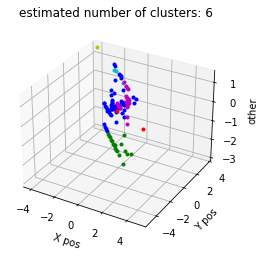

In [8]:
clusters[99].agglomerative_cluster(n_clusters=6)
clusters[99].plot(other=4)
clusters[99].generate_distance_matrices()
clusters[99].generate_relative_motion_matrices()
clusters[99].generate_average_relative_motions();

In [9]:
frame

{'timestamp': 1571844735402847046,
 'agent_index_interval': array([1893690, 1893736]),
 'ego_rotation': array([315990, 316008]),
 'ego_translation': array([277.59915161,  38.03862   , 269.53125   ])}

In [10]:
# clusters[99].average_relative_motions

In [11]:
fii = scene['frame_index_interval']
aii = frames[fii[0]]['agent_index_interval']

In [12]:
import matplotlib.pyplot as plt

In [13]:
# this needs to be tweaked. we dont need every angular velocity for every car

window = 30
angular_velocities = backpack.AngularVelocityComputer(scene, frames, agents, window=window)

/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


42.02471089363098


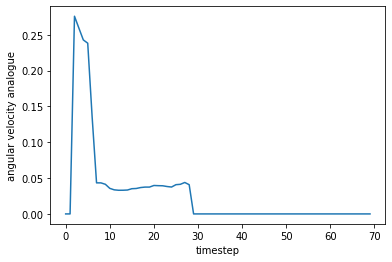

In [17]:
speeds = angular_velocities[75]
plt.ylabel('angular velocity analogue')
plt.xlabel('timestep')
plt.plot(list(range(len(speeds))), speeds)

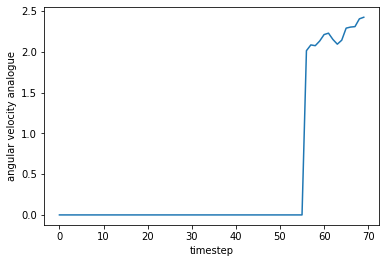

In [22]:
speeds = angular_velocities[490]
plt.ylabel('angular velocity analogue')
plt.xlabel('timestep')
plt.plot(list(range(len(speeds))), speeds)